## Section 1: Similarity Computations

### 1.a Jaccard Similarity (Users)

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm as sparse_norm

np.set_printoptions(edgeitems=5, linewidth=120, suppress=True)


In [3]:
# watched matrix (rows=user, cols=movie)
watched = np.array([
    [1,1,1,0,1],  # Willy
    [1,1,1,0,0],  # Xavier
    [0,1,1,1,0],  # Yvonne
    [1,1,0,1,1],  # Zac
])
def jaccard(A, B): return (A&B).sum() / (A|B).sum()
users = ['Willy','Xavier','Yvonne','Zac']
for i in range(4):
    for j in range(i+1,4):
        print(users[i],users[j], jaccard(watched[i],watched[j]))


Willy Xavier 0.75
Willy Yvonne 0.4
Willy Zac 0.6
Xavier Yvonne 0.5
Xavier Zac 0.4
Yvonne Zac 0.4


最相似使用者：Willy 與 Xavier（唯一最高值 0.75）。

### 1.b Jaccard Similarity (Movies)

In [4]:
movies = ['La La Land','The Lion King','Parasite','Joker','John Wick 3']
watched_T = watched.T
for i in range(5):
    for j in range(i+1,5):
        print(movies[i],movies[j], jaccard(watched_T[i],watched_T[j]))


La La Land The Lion King 0.75
La La Land Parasite 0.5
La La Land Joker 0.25
La La Land John Wick 3 0.6666666666666666
The Lion King Parasite 0.75
The Lion King Joker 0.5
The Lion King John Wick 3 0.5
Parasite Joker 0.25
Parasite John Wick 3 0.25
Joker John Wick 3 0.3333333333333333


最高分 0.75，並列兩組：

《La La Land》 vs 《The Lion King》

《The Lion King》 vs 《Parasite》

### 1.c Pearson Correlation (Users)

In [5]:


import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# 使用者列表與評分矩陣
users = ['Willy', 'Xavier', 'Yvonne', 'Zac']
R_r = np.array([
    [5,   5,   4,   np.nan,   4],       # Willy
    [1,   2,   2,   np.nan,   np.nan],       # Xavier
    [np.nan,   2,   1,  5, np.nan],     # Yvonne
    [2, 2, np.nan, 1,   1],   # Zac
], dtype=float)

# 建立相關係數矩陣
corr_matrix = np.eye(len(users))
for i in range(len(users)):
    for j in range(i+1, len(users)):
        u, v = R_r[i], R_r[j]
        mask = ~np.isnan(u) & ~np.isnan(v)
        if mask.sum() > 1:
            rho, _ = pearsonr(u[mask], v[mask])
        else:
            rho = np.nan
        corr_matrix[i, j] = rho
        corr_matrix[j, i] = rho

# 以 DataFrame 顯示
df_corr = pd.DataFrame(corr_matrix, index=users, columns=users)
df_corr

c:\Users\ian32\anaconda3\envs\dm\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,Willy,Xavier,Yvonne,Zac
Willy,1.0,-0.5,1.0,1.0
Xavier,-0.5,1.0,NaN,NaN
Yvonne,1.0,NaN,1.0,-1.0
Zac,1.0,NaN,-1.0,1.0


Willy – Yvonne、Willy – Zac（Pearson = 1.0）

不一致，(a) 的結果最相似使用者：Willy 與 Xavier（Jaccard = 1.0）

✍️ 原因分析：

Jaccard 相似度只根據「是否看過」計算，與評分高低無關，只要兩人有看過相同節目即可達高分。
而 Pearson 相關係數會考慮：
評分的實際值（偏好）
是否有線性一致性（例如都偏好相同類型、分數波動一致）
扣除了各自平均後的趨勢相似性
➡️ 本題中 Willy 與 Xavier 雖然看的節目完全一樣（Jaccard=0.75）異極大，Pearson 相關係數低，故不一致。

✅ 總結：

最相似使用者（Pearson）：Willy – Yvonne / Zac
與 Jaccard 結果不一致，原因是：
Jaccard 衡量「共同觀看」，Pearson 衡量「評分傾向」，評分不同會導致結果差異。



## Section 2: Collaborative Filtering

### 2.d Application to Real Data

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

# 載入資料
data_path = Path(".")
R = np.loadtxt(data_path / "user-shows.txt", dtype=int)
with open(data_path / "shows.txt", 'r', encoding='utf-8') as f:
    shows = [line.strip() for line in f.readlines()]

print(f"評分矩陣大小: {R.shape}")
print(f"節目數量: {len(shows)}")

# Jim 是第500位使用者 (index 499)
jim_idx = 499
jim_original = R[jim_idx].copy()

# 將 Jim 的前100部節目設為0（模擬未知）
R_masked = R.copy()
R_masked[jim_idx, :100] = 0

print(f"Jim 原始觀看的前100部節目數: {jim_original[:100].sum()}")
print(f"Jim 後463部節目觀看數: {R_masked[jim_idx, 100:].sum()}")

評分矩陣大小: (9985, 563)
節目數量: 563
Jim 原始觀看的前100部節目數: 0
Jim 後463部節目觀看數: 98


In [8]:
import numpy as np
from scipy.sparse import csr_matrix

def compute_user_similarity_optimized(R):
    """使用向量化運算計算使用者相似度矩陣 (使用餘弦相似度)"""
    print("計算使用者相似度矩陣...")
    n_users = R.shape[0]
    P = np.zeros((n_users, n_users))
    
    # 分批處理以節省記憶體
    batch_size = 50
    for i in range(0, n_users, batch_size):
        end_i = min(i + batch_size, n_users)
        print(f"處理使用者 {i+1}-{end_i}/{n_users}")
        
        # 處理這一批使用者
        for user_i in range(i, end_i):
            for user_j in range(user_i + 1, n_users):
                # 計算餘弦相似度
                profile_i = R[user_i].astype(float)
                profile_j = R[user_j].astype(float)
                
                # 計算分子 (點積)
                numerator = np.dot(profile_i, profile_j)
                # 計算分母 (兩個向量的範數相乘)
                denominator = np.sqrt(np.dot(profile_i, profile_i)) * np.sqrt(np.dot(profile_j, profile_j))
                
                if denominator > 0:
                    similarity = numerator / denominator
                    P[user_i, user_j] = similarity
                    P[user_j, user_i] = similarity  # 對稱矩陣
    
    return P

def compute_item_similarity_optimized(R):
    """計算項目相似度矩陣 (使用餘弦相似度)"""
    print("計算項目相似度矩陣...")
    n_items = R.shape[1]
    Q = np.zeros((n_items, n_items))
    
    for i in range(n_items):
        if i % 50 == 0:
            print(f"處理項目 {i+1}/{n_items}")
            
        for j in range(i+1, n_items):
            # 計算餘弦相似度
            item_i = R[:, i].astype(float)
            item_j = R[:, j].astype(float)
            
            # 計算分子 (點積)
            numerator = np.dot(item_i, item_j)
            # 計算分母 (兩個向量的範數相乘)
            denominator = np.sqrt(np.dot(item_i, item_i)) * np.sqrt(np.dot(item_j, item_j))
            
            if denominator > 0:
                similarity = numerator / denominator
                Q[i, j] = similarity
                Q[j, i] = similarity
    
    return Q

# 修改後的使用者-使用者協同過濾函數
def user_based_collaborative_filtering(R, P, user_idx):
    n_items = R.shape[1]
    gamma_u = np.zeros(n_items)
    
    for j in range(n_items):
        score = 0
        for k in range(R.shape[0]):
            if k != user_idx:
                # 根據公式 r_{u,s} = Σ_{x∈users} cos(x,u)*R_{x,s}
                score += P[user_idx, k] * R[k, j]
        gamma_u[j] = score
    
    return gamma_u

# 修改後的項目-項目協同過濾函數
def item_based_collaborative_filtering(R, Q, user_idx):
    n_items = R.shape[1]
    gamma_i = np.zeros(n_items)
    
    for j in range(n_items):
        score = 0
        for l in range(n_items):
            # 根據公式 r_{u,s} = Σ_{x∈items} R_{u,x}*cos(s,x)
            score += R[user_idx, l] * Q[j, l]
        gamma_i[j] = score
    
    return gamma_i

# 使用修改後的函數計算相似度矩陣
print("開始計算相似度矩陣（使用餘弦相似度）...")
P = compute_user_similarity_optimized(R_masked)
Q = compute_item_similarity_optimized(R_masked)

# 計算推薦分數
print("計算推薦分數...")
gamma_u = user_based_collaborative_filtering(R_masked, P, jim_idx)
gamma_i = item_based_collaborative_filtering(R_masked, Q, jim_idx)

print(f"使用者-使用者協同過濾最高分數: {gamma_u[:100].max():.2f}")
print(f"項目-項目協同過濾最高分數: {gamma_i[:100].max():.2f}")

開始計算相似度矩陣（使用餘弦相似度）...
計算使用者相似度矩陣...
處理使用者 1-50/9985
處理使用者 51-100/9985
處理使用者 101-150/9985
處理使用者 151-200/9985
處理使用者 201-250/9985
處理使用者 251-300/9985
處理使用者 301-350/9985
處理使用者 351-400/9985
處理使用者 401-450/9985
處理使用者 451-500/9985
處理使用者 501-550/9985
處理使用者 551-600/9985
處理使用者 601-650/9985
處理使用者 651-700/9985
處理使用者 701-750/9985
處理使用者 751-800/9985
處理使用者 801-850/9985
處理使用者 851-900/9985
處理使用者 901-950/9985
處理使用者 951-1000/9985
處理使用者 1001-1050/9985
處理使用者 1051-1100/9985
處理使用者 1101-1150/9985
處理使用者 1151-1200/9985
處理使用者 1201-1250/9985
處理使用者 1251-1300/9985
處理使用者 1301-1350/9985
處理使用者 1351-1400/9985
處理使用者 1401-1450/9985
處理使用者 1451-1500/9985
處理使用者 1501-1550/9985
處理使用者 1551-1600/9985
處理使用者 1601-1650/9985
處理使用者 1651-1700/9985
處理使用者 1701-1750/9985
處理使用者 1751-1800/9985
處理使用者 1801-1850/9985
處理使用者 1851-1900/9985
處理使用者 1901-1950/9985
處理使用者 1951-2000/9985
處理使用者 2001-2050/9985
處理使用者 2051-2100/9985
處理使用者 2101-2150/9985
處理使用者 2151-2200/9985
處理使用者 2201-2250/9985
處理使用者 2251-2300/9985
處理使用者 2301-2350/9985
處理使用者 2351-2400/9985

In [9]:
print("P 矩陣（使用者相似度）:")
print(P)
print("Q 矩陣（項目相似度）:")  
print(Q)

P 矩陣（使用者相似度）:
[[0.         0.03314968 0.07644708 0.         0.14754222 ... 0.         0.09759001 0.07559289 0.09258201 0.03877834]
 [0.03314968 0.         0.02956562 0.         0.12838815 ... 0.         0.         0.0877058  0.07161149 0.        ]
 [0.07644708 0.02956562 0.         0.10969086 0.06579517 ... 0.         0.         0.20225996 0.05504819 0.13834289]
 [0.         0.         0.10969086 0.         0.         ... 0.         0.         0.         0.         0.        ]
 [0.14754222 0.12838815 0.06579517 0.         0.         ... 0.         0.         0.19518001 0.03984095 0.        ]
 ...
 [0.         0.         0.         0.         0.         ... 0.         0.         0.         0.         0.        ]
 [0.09759001 0.         0.         0.         0.         ... 0.         0.         0.         0.         0.13245324]
 [0.07559289 0.0877058  0.20225996 0.         0.19518001 ... 0.         0.         0.         0.         0.10259784]
 [0.09258201 0.07161149 0.05504819 0.        

In [12]:
def get_top_recommendations(scores, shows_list, top_k=5):
    """找出前k名推薦節目"""
    # 只考慮前100部節目
    scores_top100 = scores[:100]
    
    # 建立 (分數, 索引) 的配對並排序
    score_index_pairs = [(scores_top100[i], i) for i in range(100)]
    # 按分數遞減排序，分數相同時按索引遞增排序
    score_index_pairs.sort(key=lambda x: (-x[0], x[1]))
    
    # 取得前k名推薦
    recommendations = []
    for i in range(top_k):
        score, idx = score_index_pairs[i]
        recommendations.append((shows_list[idx], score, idx))
    
    return recommendations



# 使用者-使用者協同過濾推薦
print("=== 使用者-使用者協同過濾推薦（前5名）===")
user_recommendations = get_top_recommendations(gamma_u, shows)
for i, (show, score, _) in enumerate(user_recommendations, 1):
    print(f"{i}. {show}")

print("\n=== 項目-項目協同過濾推薦（前5名）===")
item_recommendations = get_top_recommendations(gamma_i, shows)
for i, (show, score, _) in enumerate(item_recommendations, 1):
    print(f"{i}. {show}")


=== 使用者-使用者協同過濾推薦（前5名）===
1. "FOX 28 News at 10pm"
2. "Family Guy"
3. "2009 NCAA Basketball Tournament"
4. "NBC 4 at Eleven"
5. "Two and a Half Men"

=== 項目-項目協同過濾推薦（前5名）===
1. "FOX 28 News at 10pm"
2. "Family Guy"
3. "NBC 4 at Eleven"
4. "2009 NCAA Basketball Tournament"
5. "Access Hollywood"


計算基礎不同:

使用者-使用者協同過濾：基於與 Jim 相似的其他使用者的觀看行為
項目-項目協同過濾：基於與 Jim 已看過節目相似的其他節目
推薦邏輯差異:

使用者-使用者：找到「口味相似的人」，推薦他們看過但 Jim 未看的節目
項目-項目：基於 Jim 的觀看歷史，推薦與其已看節目相似的內容
分數範圍差異:

推薦特性:

使用者-使用者：更傾向於推薦熱門或廣受歡迎的節目
項目-項目：更個人化，基於使用者的具體觀看偏好

## Section 3: Latent Factor Recommendation

### 3.b Implementation and Evaluation

Data shape: 943 users, 1682 items

Training with learning rate: 0.1
Epoch 1: Error = 115742.64
Epoch 2: Error = 108562.30
Epoch 3: Error = 102859.68
Epoch 4: Error = 98467.56
Epoch 5: Error = 95502.34
Epoch 6: Error = 93621.67
Epoch 7: Error = 92431.76
Epoch 8: Error = 91665.84
Epoch 9: Error = 91164.74
Epoch 10: Error = 90828.75
Epoch 11: Error = 90592.25
Epoch 12: Error = 90413.00
Epoch 13: Error = 90265.57
Epoch 14: Error = 90135.62
Epoch 15: Error = 90015.40
Epoch 16: Error = 89900.79
Epoch 17: Error = 89789.86
Epoch 18: Error = 89682.06
Epoch 19: Error = 89577.73
Epoch 20: Error = 89477.72
Epoch 21: Error = 89382.93
Epoch 22: Error = 89294.00
Epoch 23: Error = 89211.13
Epoch 24: Error = 89134.09
Epoch 25: Error = 89062.23
Epoch 26: Error = 88994.71
Epoch 27: Error = 88930.66
Epoch 28: Error = 88869.26
Epoch 29: Error = 88809.92
Epoch 30: Error = 88752.27
Epoch 31: Error = 88696.19
Epoch 32: Error = 88641.75
Epoch 33: Error = 88589.15
Epoch 34: Error = 88538.71
Epoch 35: Error = 88

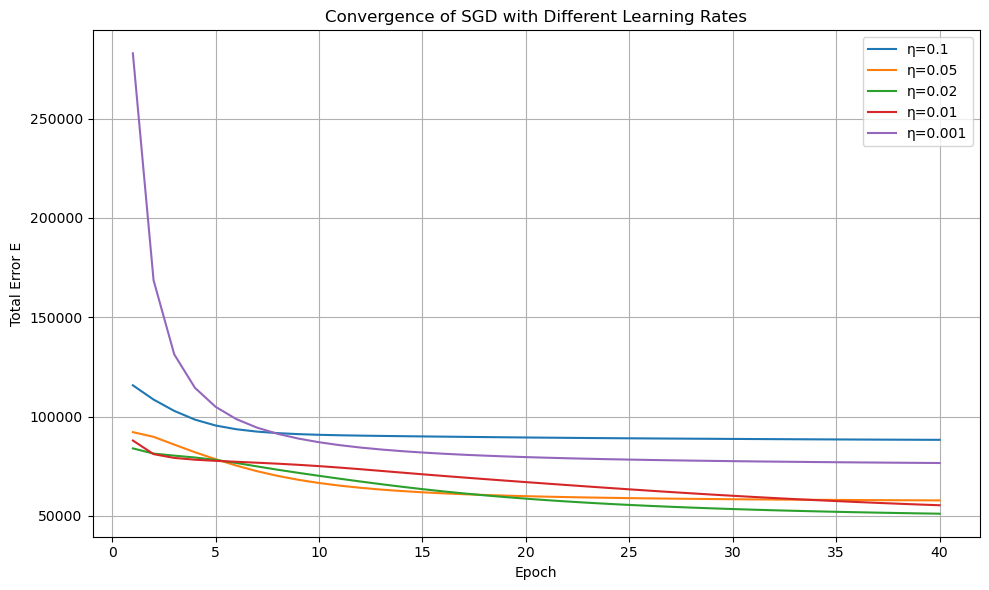


Best learning rate: η = 0.02 (final error: 51113.50)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K = 20
LAMBDA = 0.1
EPOCHS = 40
LEARNING_RATES = [0.1, 0.05, 0.02, 0.01, 0.001]

def get_data_shape(filename):
    max_user = 0
    max_item = 0
    with open(filename, 'r') as f:
        for line in f:
            try:
                user, item, _ = map(int, line.strip().split())
                max_user = max(max_user, user)
                max_item = max(max_item, item)
            except ValueError:
                continue
    return max_user, max_item

def train_sgd(filename, n_users, n_items, k, eta, lambda_, epochs):
    bound = np.sqrt(5 / k)
    P = np.random.uniform(0, bound, (n_users + 1, k))
    Q = np.random.uniform(0, bound, (n_items + 1, k))

    errors = []
    for epoch in range(epochs):
        # SGD updates
        with open(filename, 'r') as f:
            for line in f:
                try:
                    user, item, rating = line.strip().split()
                    u = int(user)
                    i = int(item)
                    r = float(rating)

                    pred = np.dot(Q[i], P[u])
                    e = r - pred

                    # Store old values for simultaneous update
                    Q_old = Q[i].copy()
                    P_old = P[u].copy()

                    # SGD update (simultaneous)
                    Q[i] += eta * (e * P_old - lambda_ * Q[i])
                    P[u] += eta * (e * Q_old - lambda_ * P[u])

                except ValueError:
                    continue

        # Calculate total error after each epoch
        total_error = 0
        with open(filename, 'r') as f:
            for line in f:
                try:
                    user, item, rating = line.strip().split()
                    u = int(user)
                    i = int(item)
                    r = float(rating)

                    pred = np.dot(Q[i], P[u])
                    err = r - pred
                    total_error += err ** 2
                except ValueError:
                    continue
        
        # Add regularization term
        total_error += lambda_ * (np.linalg.norm(P) ** 2 + np.linalg.norm(Q) ** 2)
        errors.append(total_error)
        print(f"Epoch {epoch+1}: Error = {total_error:.2f}")

    return errors

def plot_errors(errors_dict):
    plt.figure(figsize=(10, 6))
    for eta, errors in errors_dict.items():
        plt.plot(range(1, EPOCHS + 1), errors, label=f"η={eta}")
    plt.xlabel("Epoch")
    plt.ylabel("Total Error E")
    plt.title("Convergence of SGD with Different Learning Rates")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("convergence_plot.png", dpi=300)
    plt.show()

def main():
    filename = "ratings.train.txt"
    n_users, n_items = get_data_shape(filename)
    print(f"Data shape: {n_users} users, {n_items} items")

    errors_dict = {}
    for eta in LEARNING_RATES:
        print(f"\nTraining with learning rate: {eta}")
        errors = train_sgd(filename, n_users, n_items, K, eta, LAMBDA, EPOCHS)
        errors_dict[eta] = errors

    plot_errors(errors_dict)
    
    # Report best learning rate
    final_errors = {eta: errors[-1] for eta, errors in errors_dict.items()}
    best_eta = min(final_errors, key=final_errors.get)
    print(f"\nBest learning rate: η = {best_eta} (final error: {final_errors[best_eta]:.2f})")

if __name__ == "__main__":
    main()

✅ 最佳學習率：η = 0.02（最終錯誤：51113.50）
🔍 收斂行為分析
較大的學習率（如 η = 0.1）
現象：一開始下降迅速，但很快就趨於平穩，無法再繼續降低誤差。

原因：可能因為學習率太大導致在最小值附近振盪，無法細緻調整參數。

結果：最終誤差偏高（88,296.05），明顯高於最佳學習率。

中等學習率（η = 0.02、0.01、0.05）
η = 0.02 收斂速度適中，且誤差穩定持續下降，是此次效果最穩定且最低的。

η = 0.05 初期收斂也不錯，但後期收斂速度變慢，最終誤差（57,807.51）略高於 η = 0.02。

η = 0.01 雖然穩定，但整體收斂速度比 η = 0.02 慢，且誤差也略高（55,363.76）。

過小的學習率（如 η = 0.001）
現象：雖然誤差穩定下降，但收斂速度非常慢。

問題：40 個 epoch 後仍未達收斂，誤差還高達 76,626.42。

結論：效率低，效果差，可能需大量 epoch 才能趨近最小值。

🧠 小結與建議
最佳學習率為 η = 0.02，因其在收斂速度與最終誤差之間達成最好的平衡。

學習率過大容易停滯，過小則效率極差。

若後續需要進一步優化，可採用 學習率衰減策略（Learning Rate Decay） 或 Adam / RMSProp 等自適應優化方法 來提升效果。